# Task 8 – Machine Learning Models (XGBoost)

This notebook rebuilds Task 8 from scratch, focusing on a single XGBoost model for hourly demand forecasting. 

Key goals:
- prepare a clean modelling dataset with aligned timestamps and numeric features
- train an XGBoost regressor with version-agnostic settings
- evaluate performance on a held-out validation week and export predictions/metrics
- generate academic-style figures and compare results with the best statistical model from Task 7

In [13]:
# AUDIT: Diagnostics & Version Checks
import pandas as pd
import numpy as np
import xgboost as xgb
import statsmodels
import plotly
import matplotlib

print("═" * 60)
print("PACKAGE VERSIONS")
print("═" * 60)
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"xgboost: {xgb.__version__}")
print(f"statsmodels: {statsmodels.__version__}")
print(f"plotly: {plotly.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print()

def show_columns(df, name="Dataset"):
    """Display column types and missing value percentages."""
    print(f"\n{'─' * 60}")
    print(f"{name.upper()} COLUMN SUMMARY")
    print(f"{'─' * 60}")
    print(f"{'Column':<30} {'Type':<15} {'% NA':>10}")
    print(f"{'─' * 60}")
    for col in df.columns:
        pct_na = 100 * df[col].isna().sum() / len(df)
        print(f"{col:<30} {str(df[col].dtype):<15} {pct_na:>9.2f}%")
    print(f"{'─' * 60}\n")

════════════════════════════════════════════════════════════
PACKAGE VERSIONS
════════════════════════════════════════════════════════════
pandas: 1.5.3
numpy: 1.26.4
xgboost: 3.0.5
statsmodels: 0.14.5
plotly: 6.3.0
matplotlib: 3.10.7



In [14]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

ROOT = Path.cwd().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.modeling_ml import (
    set_seed,
    build_ml_dataset,
    train_xgboost,
    predict_xgboost,
    evaluate_forecast,
    align_by_index,
 )

RANDOM_SEED = 42
set_seed(RANDOM_SEED)

TARGET = "Demand"
REPORTS_DIR = ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
TABLES_DIR = REPORTS_DIR / "tables"
CHECKS_DIR = REPORTS_DIR / "checks"

for path in (FIGURES_DIR, TABLES_DIR, CHECKS_DIR):
    path.mkdir(parents=True, exist_ok=True)


def set_academic_style() -> None:
    mpl.rcParams.update({
        "figure.figsize": (10, 4),
        "axes.facecolor": "white",
        "savefig.facecolor": "white",
        "axes.grid": True,
        "grid.color": "#ECEFF3",
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
        "font.size": 11,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    })


def save_figure(fig: plt.Figure, filename: str, dpi: int = 300) -> None:
    fig.tight_layout()
    output_path = FIGURES_DIR / filename
    fig.savefig(output_path, dpi=dpi, bbox_inches="tight")
    plt.show()


def display_table(df: pd.DataFrame, filename: str) -> None:
    output_path = TABLES_DIR / filename
    df.to_csv(output_path, index=False)
    display(df)


set_academic_style()
sns.set_theme(style="whitegrid")
ENERGY_COLORS = {
    "actual": "#1f77b4",
    "xgboost": "#FFA500",
    "stat": "#2ca02c",
}

In [15]:
DATA_PATH = ROOT / "data" / "processed" / "task5_features.parquet"
print(f"Loading processed dataset from: {DATA_PATH}")

df = pd.read_parquet(DATA_PATH)
if "timestamp" not in df.columns:
    df = df.reset_index().rename(columns={"index": "timestamp"})

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

if df["timestamp"].dt.tz is not None:
    df["timestamp"] = df["timestamp"].dt.tz_convert(None)

print(f"Dataset shape: {df.shape}")
print(f"Time span: {df['timestamp'].min()} → {df['timestamp'].max()}")

# AUDIT: Show column diagnostics
show_columns(df, "Task 5 Features")

df.head()

Loading processed dataset from: /Users/samuel/EDS/Energy_Data_Science/data/processed/task5_features.parquet
Dataset shape: (8759, 17)
Time span: 2013-07-01 00:00:00 → 2014-06-30 23:00:00

────────────────────────────────────────────────────────────
TASK 5 FEATURES COLUMN SUMMARY
────────────────────────────────────────────────────────────
Column                         Type                  % NA
────────────────────────────────────────────────────────────
timestamp                      datetime64[ns]       0.00%
Demand                         float64              0.00%
hour_sin                       float64              0.00%
hour_cos                       float64              0.00%
is_weekend                     int64                0.00%
cooling_degree                 float64              0.00%
heating_degree                 float64              0.00%
temp_irradiance_interaction    float64             81.00%
Temperature                    float64              0.00%
Pressure (hPa)    

,timestamp,Demand,hour_sin,hour_cos,is_weekend,cooling_degree,heating_degree,temp_irradiance_interaction,Temperature,Pressure (hPa),Cloud_cover (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),Price
0,2013-07-01 00:00:00,0.27,0.000000,1.000000,0,0.0,4.5,NaN,13.5,1011.3,4,10.5,NaN,0,0,0.0,0.01605
1,2013-07-01 01:00:00,0.23,0.258819,0.965926,0,0.0,4.8,NaN,13.2,1010.8,27,11.9,NaN,0,0,0.0,0.00095
2,2013-07-01 02:00:00,0.26,0.500000,0.866025,0,0.0,4.9,NaN,13.1,1010.3,33,11.6,NaN,0,0,0.0,0.00060
3,2013-07-01 03:00:00,0.28,0.707107,0.707107,0,0.0,5.0,NaN,13.0,1010.3,28,11.2,NaN,2,7,30.1,0.00046
4,2013-07-01 04:00:00,0.29,0.866025,0.500000,0,0.0,4.2,NaN,13.8,1010.2,16,11.7,NaN,30,31,252.0,0.00046


In [16]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
assert df["timestamp"].is_monotonic_increasing, "Timestamps must be strictly increasing"

df[numeric_columns] = df[numeric_columns].interpolate(limit_direction="both")
df[numeric_columns] = df[numeric_columns].fillna(method="ffill").fillna(method="bfill")

if df[numeric_columns].isna().any().any():
    raise ValueError("Numeric columns still contain NaNs after filling")

FEATURE_COLS = [col for col in numeric_columns if col.lower() != TARGET.lower()]

print(f"Selected {len(FEATURE_COLS)} numeric feature columns.")
print(f"Data span: {df['timestamp'].min()} → {df['timestamp'].max()}")
FEATURE_COLS

Selected 15 numeric feature columns.
Data span: 2013-07-01 00:00:00 → 2014-06-30 23:00:00


['hour_sin',
 'hour_cos',
 'is_weekend',
 'cooling_degree',
 'heating_degree',
 'temp_irradiance_interaction',
 'Temperature',
 'Pressure (hPa)',
 'Cloud_cover (%)',
 'Wind_speed_10m (km/h)',
 'Shortwave_radiation (W/m²)',
 'direct_radiation (W/m²)',
 'diffuse_radiation (W/m²)',
 'direct_normal_irradiance (W/m²)',
 'Price']

In [17]:
VALIDATION_DAYS = 7
validation_start = df["timestamp"].max() - pd.Timedelta(days=VALIDATION_DAYS)
train_df = df[df["timestamp"] < validation_start].copy()
val_df = df[df["timestamp"] >= validation_start].copy()

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Validation window: {val_df['timestamp'].min()} → {val_df['timestamp'].max()}")

Training samples: 8590
Validation samples: 169
Validation window: 2014-06-23 23:00:00 → 2014-06-30 23:00:00


In [18]:
X_train, y_train, idx_train = build_ml_dataset(train_df, target=TARGET, feature_cols=FEATURE_COLS)
X_val, y_val, idx_val = build_ml_dataset(val_df, target=TARGET, feature_cols=FEATURE_COLS)

# AUDIT: Strict length assertions after each build
assert len(X_train) == len(y_train) == len(idx_train), f"Train length mismatch: X={len(X_train)}, y={len(y_train)}, idx={len(idx_train)}"
assert len(X_val) == len(y_val) == len(idx_val), f"Val length mismatch: X={len(X_val)}, y={len(y_val)}, idx={len(idx_val)}"

print(f"✓ Training matrix shape: {X_train.shape}, target: {y_train.shape}, index: {len(idx_train)}")
print(f"✓ Validation matrix shape: {X_val.shape}, target: {y_val.shape}, index: {len(idx_val)}")

DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: data['timestamp'].dtype=datetime64[ns], tz=no tz
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
DEBUG build_ml_dataset: idx.dtype=datetime64[ns], tz=None
✓ Training matrix shape: (8590, 15), target: (8590,), index: 8590
✓ Validation matrix shape: (169, 15), target: (169,), index: 169


In [19]:
# AUDIT: XGBoost params - NO fragile fit kwargs (callbacks/verbose/early_stopping)
# Set eval_metric on model only, not in fit()
xgb_params = {
    "n_estimators": 600,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "gamma": 0.0,
    "eval_metric": "rmse",  # AUDIT: Set on model, not fit
}

model, eval_history = train_xgboost(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    params=xgb_params,
    seed=RANDOM_SEED,
)

print(model)
print(f"Evaluation history available: {bool(eval_history)}")

[0]	validation_0-rmse:0.37103	validation_1-rmse:0.36331
[1]	validation_0-rmse:0.36702	validation_1-rmse:0.36253
[2]	validation_0-rmse:0.36321	validation_1-rmse:0.36051
[3]	validation_0-rmse:0.35952	validation_1-rmse:0.35821
[4]	validation_0-rmse:0.35619	validation_1-rmse:0.35650
[5]	validation_0-rmse:0.35308	validation_1-rmse:0.35431
[6]	validation_0-rmse:0.35073	validation_1-rmse:0.35317
[7]	validation_0-rmse:0.34809	validation_1-rmse:0.35249
[8]	validation_0-rmse:0.34598	validation_1-rmse:0.35146
[9]	validation_0-rmse:0.34346	validation_1-rmse:0.35023
[10]	validation_0-rmse:0.34113	validation_1-rmse:0.34850
[11]	validation_0-rmse:0.33896	validation_1-rmse:0.34725
[12]	validation_0-rmse:0.33716	validation_1-rmse:0.34691
[13]	validation_0-rmse:0.33524	validation_1-rmse:0.34590
[14]	validation_0-rmse:0.33336	validation_1-rmse:0.34562
[15]	validation_0-rmse:0.33170	validation_1-rmse:0.34478
[16]	validation_0-rmse:0.32988	validation_1-rmse:0.34426
[17]	validation_0-rmse:0.32818	validation

In [20]:
y_pred = predict_xgboost(model, X_val)

# AUDIT: Use align_by_index helper to ensure timestamp alignment
common_idx, s_true, s_pred = align_by_index(y_val, y_pred, idx_val, idx_val)
print(f"✓ Aligned {len(common_idx)} timestamps for evaluation")
assert len(s_true) == len(s_pred), "Prediction and actual lengths mismatch"

ml_split_predictions_df = pd.DataFrame(
    {
        "timestamp": common_idx,
        "Actual": s_true.values,
        "XGBoost": s_pred.values,
    }
)
display_table(ml_split_predictions_df, "08_ml_split_predictions.csv")
print("Predictions saved and displayed.")

metrics = evaluate_forecast(s_true.values, s_pred.values)
ml_split_metrics_df = pd.DataFrame(
    [{**metrics, "model_name": "XGBoost", "evaluation": "Whole-train split"}]
)
display_table(ml_split_metrics_df, "08_ml_split_metrics.csv")
print("Metrics saved and displayed.")

ml_split_metrics_df

ALIGN: true_index[:3]=DatetimeIndex(['2014-06-23 23:00:00', '2014-06-24 00:00:00',
               '2014-06-24 01:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None), pred_index[:3]=DatetimeIndex(['2014-06-23 23:00:00', '2014-06-24 00:00:00',
               '2014-06-24 01:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)
ALIGN: true_index[:3]=DatetimeIndex(['2014-06-23 23:00:00', '2014-06-24 00:00:00',
               '2014-06-24 01:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None), pred_index[:3]=DatetimeIndex(['2014-06-23 23:00:00', '2014-06-24 00:00:00',
               '2014-06-24 01:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)
✓ Aligned 169 timestamps for evaluation


,timestamp,Actual,XGBoost
0,2014-06-23 23:00:00,0.27,0.228141
1,2014-06-24 00:00:00,0.28,0.240080
2,2014-06-24 01:00:00,0.24,0.217874
3,2014-06-24 02:00:00,0.26,0.252052
4,2014-06-24 03:00:00,0.29,0.343897
...,...,...,...
164,2014-06-30 19:00:00,2.32,0.552002
165,2014-06-30 20:00:00,0.99,0.587806
166,2014-06-30 21:00:00,0.50,0.425751
167,2014-06-30 22:00:00,0.35,0.461393


Predictions saved and displayed.


,MAE,RMSE,nRMSE,model_name,evaluation
0,0.21545,0.36563,0.166195,XGBoost,Whole-train split


Metrics saved and displayed.


,MAE,RMSE,nRMSE,model_name,evaluation
0,0.21545,0.36563,0.166195,XGBoost,Whole-train split


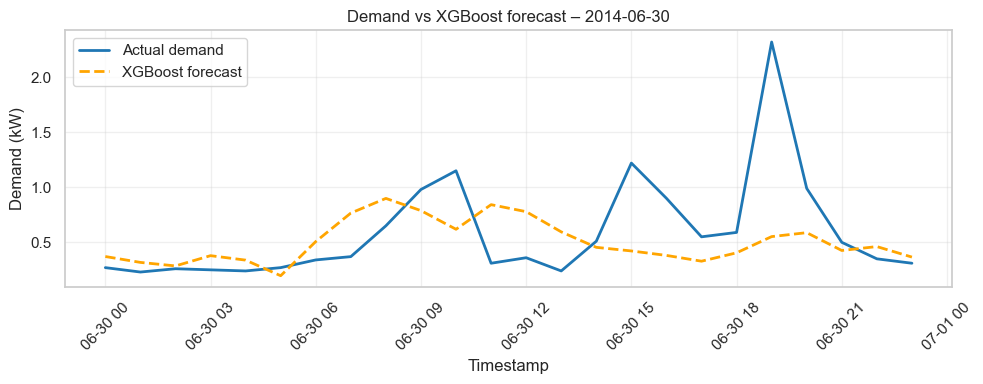

Forecast overlay saved and displayed.


In [21]:
forecast_df = pd.DataFrame({"Actual": s_true, "XGBoost": s_pred})
if getattr(forecast_df.index, "tz", None) is not None:
    forecast_df.index = forecast_df.index.tz_convert(None)

selected_day = forecast_df.index.normalize().unique()[-1]
day_mask = forecast_df.index.normalize() == selected_day
day_df = forecast_df.loc[day_mask]

fig, ax = plt.subplots()
ax.plot(day_df.index, day_df["Actual"], label="Actual demand", color=ENERGY_COLORS["actual"], linewidth=2)
ax.plot(day_df.index, day_df["XGBoost"], label="XGBoost forecast", color=ENERGY_COLORS["xgboost"], linewidth=2, linestyle="--")
ax.set_title(f"Demand vs XGBoost forecast – {selected_day.date()}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Demand (kW)")
ax.legend()
ax.grid(alpha=0.3)
ax.tick_params(axis="x", rotation=45)

save_figure(fig, "08_forecast_overlay.png")
print("Forecast overlay saved and displayed.")

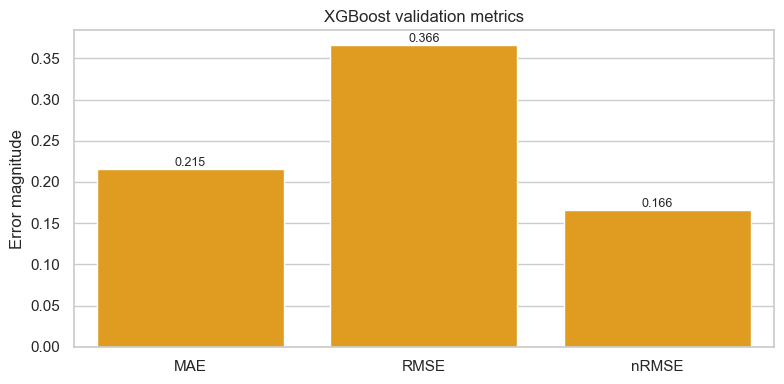

Metrics summary saved and displayed.


In [22]:
metrics_long = ml_split_metrics_df.melt(
    id_vars=["model_name", "evaluation"],
    value_vars=["MAE", "RMSE", "nRMSE"],
    var_name="Metric",
    value_name="Value",
)

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=metrics_long, x="Metric", y="Value", color=ENERGY_COLORS["xgboost"], ax=ax)
ax.set_title("XGBoost validation metrics")
ax.set_xlabel("")
ax.set_ylabel("Error magnitude")
for bar in ax.patches:
    ax.annotate(f"{bar.get_height():.3f}", (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center", va="bottom", fontsize=9)
ax.tick_params(axis="x", rotation=0)

save_figure(fig, "08_metrics_summary.png")
print("Metrics summary saved and displayed.")

,feature,importance
0,hour_sin,0.100656
1,hour_cos,0.095648
2,Temperature,0.079221
3,heating_degree,0.068628
4,Price,0.068232
5,diffuse_radiation (W/m²),0.067320
6,direct_normal_irradiance (W/m²),0.064057
7,Wind_speed_10m (km/h),0.062143
8,Shortwave_radiation (W/m²),0.061702
9,Pressure (hPa),0.060624


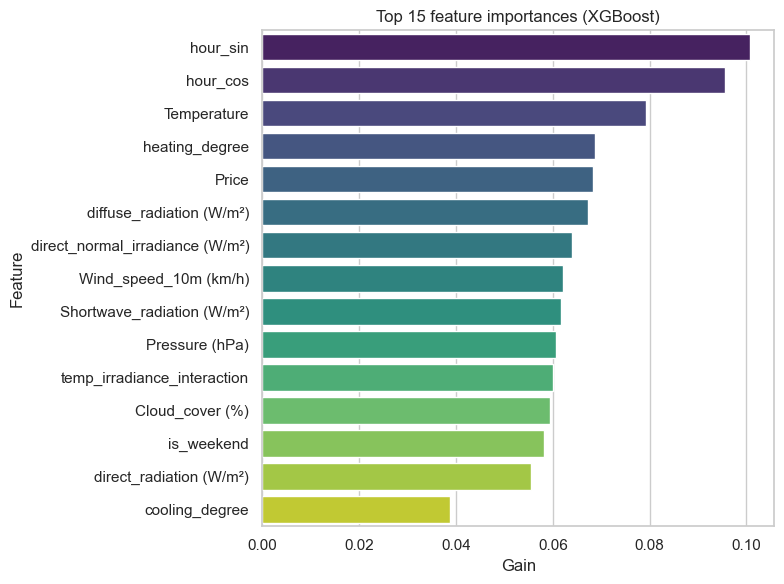

Feature importance saved and displayed.


In [23]:
feature_importances = pd.Series(model.feature_importances_, index=FEATURE_COLS)
top_features = feature_importances.sort_values(ascending=False).head(15)

top_features_df = top_features.reset_index()
top_features_df.columns = ["feature", "importance"]
display_table(top_features_df, "08_feature_importance.csv")

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis", ax=ax)
ax.set_title("Top 15 feature importances (XGBoost)")
ax.set_xlabel("Gain")
ax.set_ylabel("Feature")

save_figure(fig, "08_feature_importance.png")
print("Feature importance saved and displayed.")

In [24]:
comparison_rows = []
stat_predictions_path = TABLES_DIR / "stats_single_split_predictions.csv"

if stat_predictions_path.exists():
    stat_df = pd.read_csv(stat_predictions_path, parse_dates=["timestamp"])
    stat_df = stat_df.sort_values(["model_name", "timestamp"])

    for model_name, group in stat_df.groupby("model_name"):
        group_idx = pd.Index(group["timestamp"], name="timestamp")
        group_true = pd.Series(group["y_true"].astype(float).values, index=group_idx)
        group_pred = pd.Series(group["y_pred"].astype(float).values, index=group_idx)
        overlap = group_idx.intersection(common_idx)
        if overlap.empty:
            continue
        aligned_true = group_true.loc[overlap]
        aligned_pred = group_pred.loc[overlap]
        stats_metrics = evaluate_forecast(aligned_true.values, aligned_pred.values)
        comparison_rows.append({
            **stats_metrics,
            "model_name": model_name,
            "evaluation": "Whole-train split (statistical)",
        })

    comparison_rows.append({
        **metrics,
        "model_name": "XGBoost",
        "evaluation": "Whole-train split (ML)",
    })

    if comparison_rows:
        comparison_df = pd.DataFrame(comparison_rows)
        display_table(comparison_df, "08_best_stat_vs_ml_metrics.csv")
        print("Comparison metrics saved and displayed.")
    else:
        print("No overlapping timestamps between statistical and ML predictions; comparison skipped.")
else:
    print("Statistical prediction file not found; skipping comparison.")

,MAE,RMSE,nRMSE,model_name,evaluation
0,0.21545,0.36563,0.166195,XGBoost,Whole-train split (ML)


Comparison metrics saved and displayed.
